In [1]:
#include "TCanvas.h"
#include "TH1.h" 
#include "TLegend.h" 
#include <iostream>
#include <stdio.h>
#include "Constants.h"

using namespace std;

In [2]:
// Plots optimal high cut on the invariant hadronic mass, W
float Plot_optimal_cut()

{
// Setup
    gStyle->SetOptStat(false);  // Disable status box

    TFile* inputFile = new TFile("e4nu_test.root");  // Open ROOT file as input
    inputFile->ls();

    TTree* tree = (TTree*)inputFile->Get("gst");    // Load the ntuple from the file.

// Create cuts (default is 1 pion (plus or minus)) NOTE: we are not including pion 0 (nfpi0) in this case unless you want to

    string qel_cut = "qel  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";    // QE cuts
    string dis_cut = "dis  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";    // DIS cuts
    string mec_cut = "mec  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";    // MEC cuts
    string res_cut = "res  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";    // RES cuts
    string resid_0_cut = "res && resid == 0  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";  // Delta 1232 Cuts
    string resid_1_cut = "res && resid == 1  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";  // kS11_1535 RES cuts
    string resid_2_cut = "res && resid == 2  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";  // kD13_1520 RES cuts
    string resid_3_cut = "res && resid == 3  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";  // kS11_1650 RES cuts

    //Initialize W cut parameters
    float Max_W_cut = 1.8;  // Value of W to stop calculating
    float Min_W_cut = 1;    // Value of W to begin calculating
    float step_size = 0.01; // Step size of W for calculation
    int steps = (Max_W_cut - Min_W_cut) * (1 / step_size) + 1;  // Number of steps between max W and min W (notice this is an integer and is subject to rounding)

    //Initialize arrays for plotting
    float pur_x_eff[steps]; //Purity times Efficiency  (y value of plot)
    float Eff_new[steps];   //Efficiency (y value of plot)
    float Pur_new[steps];   //Purity (y value of plot)
    float W[steps];         //Value of W (x value of plot)

    //Fill in W array with appropriate values (1.1, 1.2 etc.)
    for (int i = 0; i < steps; ++i)
    {
        W[i] = Min_W_cut + (i * step_size);
    }

    float resid_total = tree->GetEntries(resid_0_cut.c_str()); // # total Delta 1232 events from root file

    //Calculate purity and efficiency for loop
    for (int i = 0; i < steps; ++i)
    {
        string W_0_cut = Form("resid ==0  && (nfpip + nfpim == 1) && nfpi0 == 0 && W<=%f", W[i]); //define cut on W for every step for signal
        float resid_cut_new = tree->GetEntries(W_0_cut.c_str()); // calculate Delta 1232 events within new cut
        Eff_new[i] = resid_cut_new / resid_total; // calculate Efficiency
        string signal_background = Form("(nfpip + nfpim == 1) && nfpi0 == 0 &&  W<=%f", W[i]);// calculate signal background
        float n_total_cut_new = tree->GetEntries(signal_background.c_str());    //Save new signal background as a float

        if (n_total_cut_new == 0) //avoid dividing by zero
            Pur_new[i] = 0;
        else
            Pur_new[i] = resid_cut_new / n_total_cut_new; // calculate purity
        pur_x_eff[i] = Eff_new[i] * Pur_new[i]; // calculate new element
    }
    // create graph of purity and efficiency as a function of W

    TGraph* gr = new TGraph(steps, W, pur_x_eff);// Purity x Efficiency graph
    TGraph* gr2 = new TGraph(steps, W, Eff_new); //Efficecny Graph
    TGraph* gr3 = new TGraph(steps, W, Pur_new); //Purity Graph

    gr->GetXaxis()->SetTitle("High Cut on W"); //Label x Axis

    //set color of graphs

    gr->SetLineColor(kRed);
    gr2->SetLineColor(kBlue);
    gr3->SetLineColor(kGreen);

    //Create canvas

    TCanvas* c2 = new TCanvas("c2", "Graph Draw Options", 200, 10, 1920, 1080);

    TMultiGraph* mg = new TMultiGraph();
    mg->Add(gr);
    mg->Add(gr2);
    mg->Add(gr3);
    mg->SetTitle("Optimal Cut for 2.2GeV Electron Beam (1 #pi^{#pm} only) ;High Cut on W; Value");
    mg->GetXaxis()->CenterTitle(true);
    mg->GetYaxis()->CenterTitle(true);


    //find where purity x efficiency is max
    const int N = sizeof(pur_x_eff) / sizeof(int);
    int max_index = distance(pur_x_eff, max_element(pur_x_eff, pur_x_eff + N)); 
    // Create dashed line at max value of pur x eff

    TLine* l = new TLine(W[max_index], 0, W[max_index], 1);
    l->SetLineColor(kBlack);
    l->SetLineStyle(10);
    l->SetLineWidth(2);
    mg->Draw("AC*");
    l->Draw("SAME");

    //Print optimal values in legend as strings

    string textW = "Optimal Cut: W =  ";//print value of optimal W 
    textW += to_string(W[max_index]); 

    string textPur = "Purity (Optimal Purity: "; //print value of optimal purity
        textPur += to_string(Pur_new[max_index]);
        textPur += ")";

        string textPxE = "Purity x Efficiency (Optimal Value: ";//print value of optimal purity times efficiency
        textPxE += to_string(pur_x_eff[max_index]);
        textPxE += ")";

        string textEff = "Efficiency (Optimal Efficiency: ";//print value of optimal efficiency
        textEff += to_string(Eff_new[max_index]);
        textEff += ")";

    // Create legend

    auto legend = new TLegend(0.65, 0.2, 0.9, 0.4); 
    legend->SetHeader("Legend", "C");
    legend->AddEntry(gr, Form("%s",textPxE.c_str()), "l");
    legend->AddEntry(gr2, Form("%s",textEff.c_str()), "l");
    legend->AddEntry(gr3, Form("%s",textPur.c_str()), "l");
    legend->AddEntry(l, Form("%s",textW.c_str()), "l");
    legend->Draw();
    
    return W[max_index]; //Save best W as float 
    //c2->SaveAs("PurxEff_C12_2GeV_part2.png"); //Save canvas as png
}

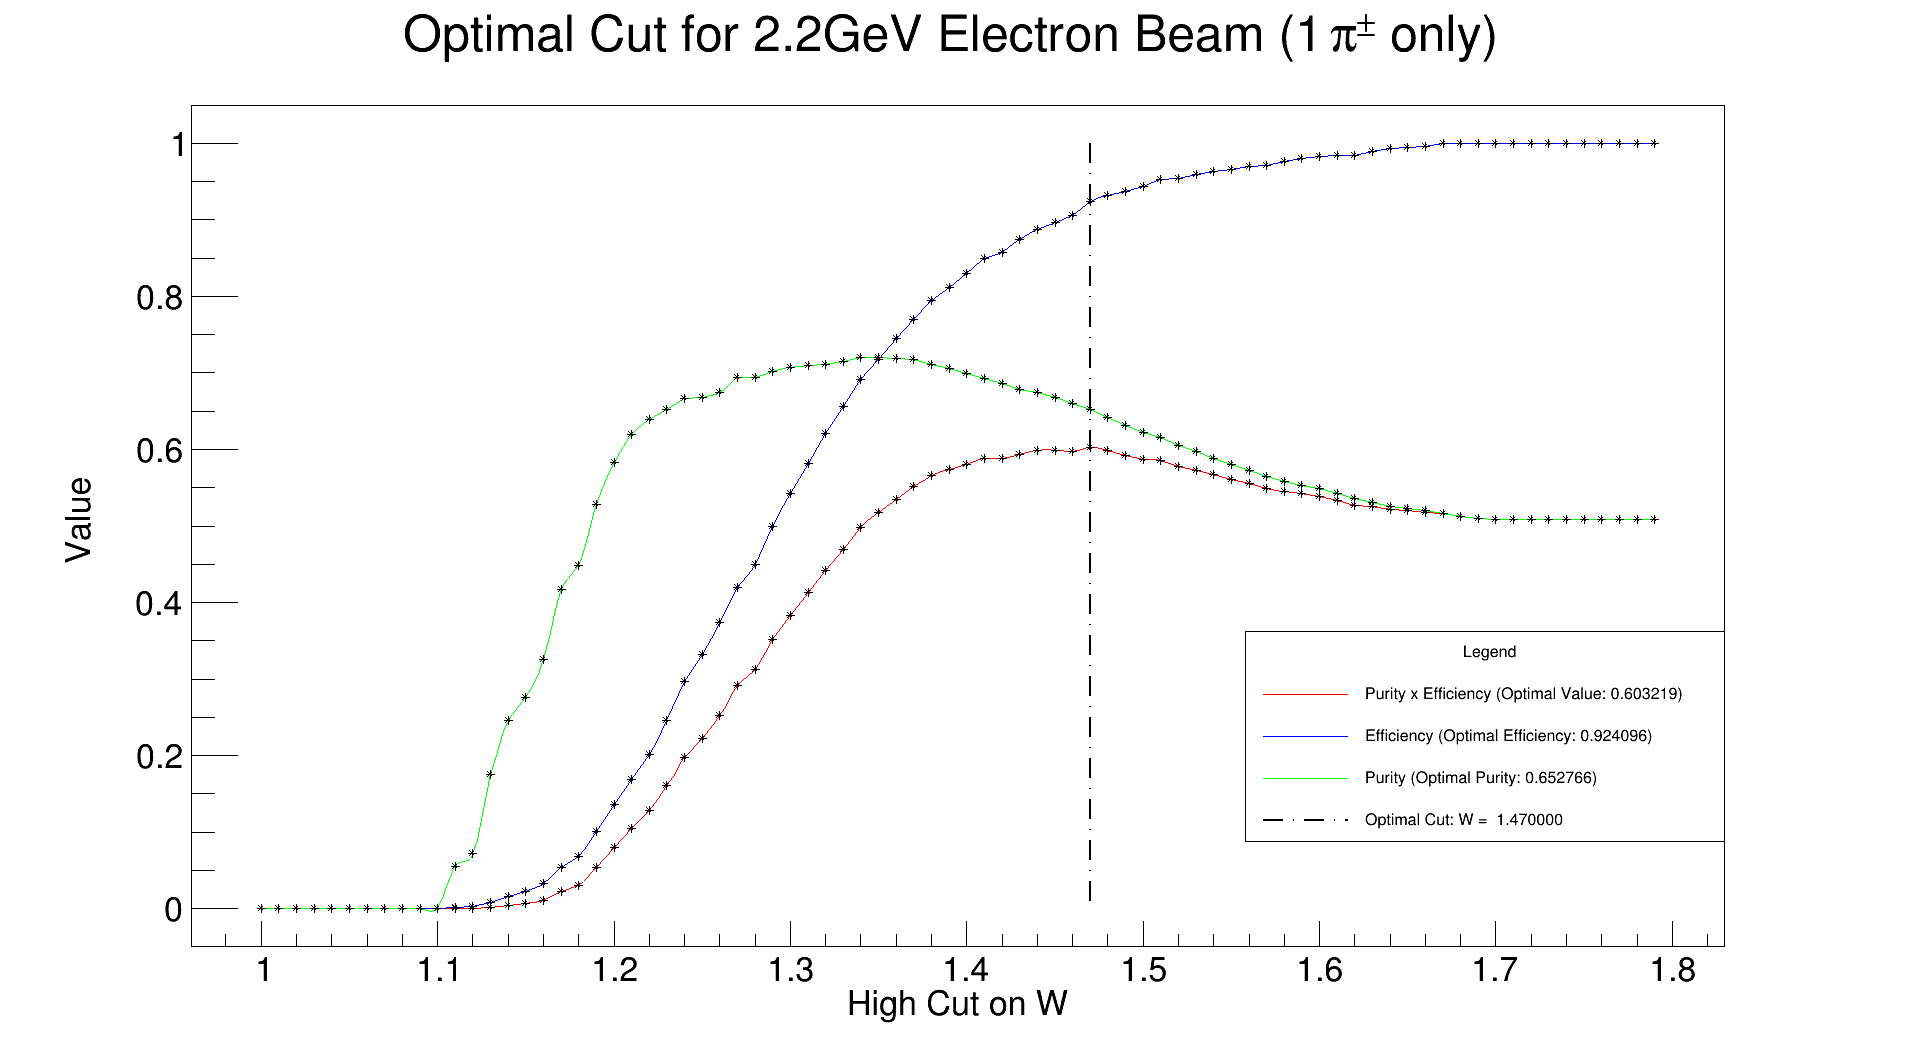

TFile**		e4nu_test.root	
 TFile*		e4nu_test.root	
  KEY: TTree	gst;1	GENIE Summary Event Tree


In [3]:
float Wopt = Plot_optimal_cut();
c2->Draw();

In [4]:
// Plots number of expected events as a function of the invariant hadronic mass, W
void Plot_W_Signal()
{
    // Disable status box
    gStyle->SetOptStat(false);

    // Open the input ROOT file
    TFile* inputFile_1 = new TFile("e4nu_test.root");
    inputFile_1->ls();

    // Load the ntuple from the file. 
    TTree* tree_1 = (TTree*)inputFile_1->Get("gst");  

    // Cuts for only 1 pion in the final state (for neutrino files consider adding "cc" in these cuts as well)
    string qel_mn_cut = "qel  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";
    string dis_mn_cut = "dis  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";
    string mec_mn_cut = "mec  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";
    string res_mn_cut = "res  && resid != 0 && (nfpip + nfpim  == 1) && nfpi0 == 0 "; //note we are not including nfpi0 

    string resid_0_mn_cut = "res && resid == 0  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";// Delta 1232 RES events

    //Higher RES events
    //string resid_1_cut = "res && resid == 1  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";
    //string resid_2_cut = "res && resid == 2  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";
    //string resid_3_cut = "res && resid == 3  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";

    string background_cut = "resid != 0 && (nfpip + nfpim  == 1) && nfpi0 == 0 ";

    // Take in full signal
    TH1D* h_W = new TH1D("h_W", "Invariant Hadronic Mass For Argon 40 #nu^{#mu}", 100, 0, 3);
    tree_1->Draw("W>>h_W");
    int n_total = tree_1->GetEntries();
    //Plot RES Events

    TH1D* h1_RES = new TH1D("h1_RES", "Invariant Hadronic Mass For Argon 40 #nu", 100, 0, 3); 
    tree_1->Draw("W>>h1_RES", res_mn_cut.c_str()); 

    //Plot DIS events
    TH1D* h1_DIS = new TH1D("h1_DIS", "Invariant Hadronic Mass For Argon 40 #nu", 100, 0, 3); 
    tree_1->Draw("W>>h1_DIS", dis_mn_cut.c_str());

    //Plot MEC events
    TH1D* h1_MEC = new TH1D("h1_MEC", "Invariant Hadronic Mass For Argon 40 #nu", 100, 0, 3);
    tree_1->Draw("W>>h1_MEC", mec_mn_cut.c_str());

    //Plot qel events
    TH1D* h1_qel = new TH1D("h1_qel", "Invariant Hadronic Mass For Argon 40 #nu", 100, 0, 3);
    tree_1->Draw("W>>h1_qel", qel_mn_cut.c_str());

    //Add all background
    TH1D* h1_Background = new TH1D("h1_Background", "Background Signal", 100, 0, 3);
    tree_1->Draw("W>>h1_Background", background_cut.c_str());

    //Plot W for res events (2D)
    TH1D* h1_Wres_id_0 = new TH1D("h_Wres_id_0", "{}^{12}C 1.1GeV Electron #Delta Resonances; W(GeV); Events / 50 MeV", 100, 0, 3);
    tree_1->Draw("W>>h_Wres_id_0", resid_0_mn_cut.c_str());
    h1_Wres_id_0->SetLineColor(kRed);
    h1_Wres_id_0->SetLineWidth(4);
    
    //Create stacked histogram for background signals

    THStack* hs_background = new THStack("hs_background", "{}^{12}C 2.2GeV Electron #Delta Resonances; W(GeV); Events / 50 MeV");

    hs_background->Add(h1_MEC);
    h1_MEC->SetFillColor(kOrange);
    hs_background->Add(h1_qel);
    h1_qel->SetFillColor(kPink);
    hs_background->Add(h1_RES);
    h1_RES->SetFillColor(kGreen);
    hs_background->Add(h1_DIS);
    h1_DIS->SetFillColor(kBlue);

    // Create canvas
    TCanvas* c1 = new TCanvas("c1", "stacked hists", 10, 10, 1920, 1080);
    h1_Wres_id_0->Draw("HIST");
    hs_background->Draw("HIST SAME");
    

    // Add legend
    auto legend = new TLegend(0.68, 0.68, 0.9, 0.9);
    legend->SetHeader("Legend", "C");
    legend->AddEntry(h1_Wres_id_0, Form("#Delta 1232 Resonances (%lld)", tree_1->GetEntries(resid_0_mn_cut.c_str())), "l");
    legend->AddEntry(h1_qel, Form("QE (%lld)", tree_1->GetEntries(qel_mn_cut.c_str())), "f");
    legend->AddEntry(h1_RES, Form("All other RES (%lld)", tree_1->GetEntries(res_mn_cut.c_str())), "f");
    legend->AddEntry(h1_MEC, Form("MEC (%lld)", tree_1->GetEntries(mec_mn_cut.c_str())), "f");
    legend->AddEntry(h1_DIS, Form("DIS (%lld)", tree_1->GetEntries(dis_mn_cut.c_str())), "f");
    legend->Draw();

    // Save your output as an image file, so you can use it in presentations, papers etc
    //c1.SaveAs("W_Signal_C12_1GeV_part2.png");
}

In [5]:
//Plot_W_Signal();
//c1->Draw();

In [6]:
// Plots number of expected events as a function of the invariant hadronic mass, W
void Plot_W_Signal_modified(float Wopt)
{
    //convert float to string
    string Woptimum = to_string(Wopt);
    
    // Disable status box
    gStyle->SetOptStat(false);

    // Open the input ROOT file
    TFile* inputFile_1 = new TFile("e4nu_test.root");
    inputFile_1->ls();

    // Load the ntuple from the file. 
    TTree* tree_1 = (TTree*)inputFile_1->Get("gst");  

    // Cuts for only 1 pion in the final state (for neutrino files consider adding "cc" in these cuts as well)
    string qel_mn = "qel  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";
    string dis_mn = "dis  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";
    string mec_mn = "mec  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";
    string res_mn = "res  && resid != 0 && (nfpip + nfpim  == 1) && nfpi0 == 0 "; //note we are not including nfpi0
    
    string resid_0_mn = "res && resid == 0  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";// Delta 1232 RES events
    
    // Including energy cuts
    string qel_mn_cut = Form("qel  && (nfpip + nfpim  == 1) && nfpi0 == 0 && W <= (%s)",Woptimum.c_str());
    string dis_mn_cut = Form("dis  && (nfpip + nfpim  == 1) && nfpi0 == 0 && W <= (%s)",Woptimum.c_str());
    string mec_mn_cut = Form("mec  && (nfpip + nfpim  == 1) && nfpi0 == 0 && W <= (%s)",Woptimum.c_str());
    string res_mn_cut = Form("res  && resid != 0 && (nfpip + nfpim  == 1) && nfpi0 == 0 && W <= (%s)",Woptimum.c_str()); //note we are not including nfpi0 

    string resid_0_mn_cut = Form("res && resid == 0  && (nfpip + nfpim  == 1) && nfpi0 == 0 && W <= (%s)",Woptimum.c_str());// Delta 1232 RES events

    //Higher RES events
    //string resid_1_cut = "res && resid == 1  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";
    //string resid_2_cut = "res && resid == 2  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";
    //string resid_3_cut = "res && resid == 3  && (nfpip + nfpim  == 1) && nfpi0 == 0 ";

    string background_cut = "resid != 0 && (nfpip + nfpim  == 1) && nfpi0 == 0 ";

    // Take in full signal
    TH1D* h_W = new TH1D("h_W", "Invariant Hadronic Mass For Argon 40 #nu^{#mu}", 100, 0, 3);
    tree_1->Draw("W>>h_W");
    int n_total = tree_1->GetEntries();
    
    //Plot RES Events
    TH1D* h1_RES = new TH1D("h1_RES", "Invariant Hadronic Mass For Argon 40 #nu", 100, 0, 3); 
    TH1D* h1_RES_all = new TH1D("h1_RES_all", "Invariant Hadronic Mass For Argon 40 #nu", 100, 0, 3); 
    tree_1->Draw("W>>h1_RES", res_mn_cut.c_str());
    tree_1->Draw("W>>h1_RES_all",res_mn.c_str());

    //Plot DIS events
    TH1D* h1_DIS = new TH1D("h1_DIS", "Invariant Hadronic Mass For Argon 40 #nu", 100, 0, 3);
    TH1D* h1_DIS_all = new TH1D("h1_DIS_all", "Invariant Hadronic Mass For Argon 40 #nu", 100, 0, 3);
    tree_1->Draw("W>>h1_DIS", dis_mn_cut.c_str());
    tree_1->Draw("W>>h1_DIS_all",dis_mn.c_str());

    //Plot MEC events
    TH1D* h1_MEC = new TH1D("h1_MEC", "Invariant Hadronic Mass For Argon 40 #nu", 100, 0, 3);
    TH1D* h1_MEC_all = new TH1D("h1_MEC_all", "Invariant Hadronic Mass For Argon 40 #nu", 100, 0, 3);
    tree_1->Draw("W>>h1_MEC", mec_mn_cut.c_str());
    tree_1->Draw("W>>h1_MEC_all",mec_mn.c_str());

    //Plot qel events
    TH1D* h1_qel = new TH1D("h1_qel", "Invariant Hadronic Mass For Argon 40 #nu", 100, 0, 3);
    TH1D* h1_qel_all = new TH1D("h1_qel_all", "Invariant Hadronic Mass For Argon 40 #nu", 100, 0, 3);
    tree_1->Draw("W>>h1_qel", qel_mn_cut.c_str());
    tree_1->Draw("W>>h1_qel_all",qel_mn.c_str());

    //Add all background
    TH1D* h1_Background = new TH1D("h1_Background", "Background Signal", 100, 0, 3);
    tree_1->Draw("W>>h1_Background", background_cut.c_str());

    //Plot W for res events (2D)
    TH1D* h1_Wres_id_0 = new TH1D("h_Wres_id_0", "{}^{12}C 1.1GeV Electron #Delta Resonances; W(GeV); Events / 50 MeV", 100, 0, 3);
    TH1D* h1_Wres_id_0_all = new TH1D("h_Wres_id_0_all", "{}^{12}C 1.1GeV Electron #Delta Resonances; W(GeV); Events / 50 MeV", 100, 0, 3);
    tree_1->Draw("W>>h_Wres_id_0", resid_0_mn_cut.c_str());
    tree_1->Draw("W>>h_Wres_id_0_all",resid_0_mn.c_str());
    h1_Wres_id_0->SetLineColor(kRed);
    h1_Wres_id_0->SetLineWidth(4);
    h1_Wres_id_0_all->SetLineColor(kRed);
    h1_Wres_id_0_all->SetLineWidth(4);
    
    //Create stacked histogram for background signals

    THStack* hs_background = new THStack("hs_background", "{}^{12}C 2.2GeV Electron #Delta Resonances; W(GeV); Events / 50 MeV");
    THStack* hs_background_all = new THStack("hs_background_all", "{}^{12}C 2.2GeV Electron #Delta Resonances; W(GeV); Events / 50 MeV");
    
    hs_background->Add(h1_MEC);
    h1_MEC->SetFillColorAlpha(kOrange,0.2);
    hs_background->Add(h1_qel);
    h1_qel->SetFillColorAlpha(kPink,0.2);
    hs_background->Add(h1_RES);
    h1_RES->SetFillColorAlpha(kGreen,0.2);
    hs_background->Add(h1_DIS);
    h1_DIS->SetFillColorAlpha(kBlue,0.2);
    
    hs_background_all->Add(h1_MEC_all);
    h1_MEC_all->SetFillColorAlpha(kOrange,0.2);
    hs_background_all->Add(h1_qel_all);
    h1_qel_all->SetFillColorAlpha(kPink,0.2);
    hs_background_all->Add(h1_RES_all);
    h1_RES_all->SetFillColorAlpha(kGreen,0.2);
    hs_background_all->Add(h1_DIS_all);
    h1_DIS_all->SetFillColorAlpha(kBlue,0.2);

    // Create canvas
    TCanvas* c1 = new TCanvas("c1", "stacked hists", 10, 10, 1920, 1080);
    h1_Wres_id_0_all->Draw("HIST");
    hs_background_all->Draw("HIST SAME");
    
    //Draw a line over the histogram at the cut
    TLine* l = new TLine(Wopt, 0, Wopt, 110);
    l->SetLineColor(kBlack);
    l->SetLineStyle(1);
    l->SetLineWidth(3);
    l->Draw("SAME");
    

    // Add legend for cut events
    auto legend_cut = new TLegend(0.68, 0.46, 0.9, 0.68);
    legend_cut->SetHeader("Cut Events", "C");
    legend_cut->AddEntry(l,Form("Cut at (%s) GeV",Woptimum.c_str()),"l");
    legend_cut->AddEntry(h1_Wres_id_0, Form("#Delta 1232 Resonances (%lld)", tree_1->GetEntries(resid_0_mn_cut.c_str())), "l");
    legend_cut->AddEntry(h1_qel, Form("QE (%lld)", tree_1->GetEntries(qel_mn_cut.c_str())), "f");
    legend_cut->AddEntry(h1_RES, Form("All other RES (%lld)", tree_1->GetEntries(res_mn_cut.c_str())), "f");
    legend_cut->AddEntry(h1_MEC, Form("MEC (%lld)", tree_1->GetEntries(mec_mn_cut.c_str())), "f");
    legend_cut->AddEntry(h1_DIS, Form("DIS (%lld)", tree_1->GetEntries(dis_mn_cut.c_str())), "f");
    legend_cut->Draw();
    
    // Add legend for all events
    auto legend_tot = new TLegend(0.68, 0.68, 0.9, 0.9);
    legend_tot->SetHeader("All Events", "C");
    legend_tot->AddEntry(h1_Wres_id_0_all, Form("#Delta 1232 Resonances (%lld)", tree_1->GetEntries(resid_0_mn.c_str())), "l");
    legend_tot->AddEntry(h1_qel, Form("QE (%lld)", tree_1->GetEntries(qel_mn.c_str())), "f");
    legend_tot->AddEntry(h1_RES, Form("All other RES (%lld)", tree_1->GetEntries(res_mn.c_str())), "f");
    legend_tot->AddEntry(h1_MEC, Form("MEC (%lld)", tree_1->GetEntries(mec_mn.c_str())), "f");
    legend_tot->AddEntry(h1_DIS, Form("DIS (%lld)", tree_1->GetEntries(dis_mn.c_str())), "f");
    legend_tot->Draw();

    // Save your output as an image file, so you can use it in presentations, papers etc
    //c1->SaveAs("Reproduced_Results.png");
}

In [7]:
%jsroot on

//Plot_W_Signal_modified(Wopt);
//c1->Draw();

TFile**		e4nu_test.root	
 TFile*		e4nu_test.root	
  KEY: TTree	gst;1	GENIE Summary Event Tree


Info in <TCanvas::Print>: png file Reproduced_Results.png has been created


## Calorimetric Reconstruction

In [ ]:
void calorimetric_reconstruction(float Wopt){
    
    //convert float to string
    string Woptimum = to_string(Wopt);
    
    // Disable status box
    gStyle->SetOptStat(false);

    // Open the input ROOT file
    TFile* inputFile = new TFile("e4nu_test.root");
    inputFile->ls();

    // Load the ntuple from the file. 
    TTree* tree = (TTree*)inputFile->Get("gst"); 
    
    //Cut for the events we care about
    tree->Draw(">>elist", "(nfpip + nfpim  == 1) && nfpi0 == 0 && nfp == 1", "entrylist");
    TEntryList *elist = (TEntryList*)gDirectory->Get("elist");
    
    //Initialise the required variables OVER A FOR LOOP
    for (i = 0; i < elist->GetN(); i++){
        
        tree->GetEntry(elist->GetEntry(i)); //Get the required entry
        
        double_t qel, mes, dis, rec;
        tree->SetBranchAddress("qel",&qel);
        tree->SetBranchAddress("mes",&mes);
        tree->SetBranchAddress("dis",&dis);
        tree->SetBranchAddress("rec",&rec);
        
    
        double_t el, ep, Epi;
        tree->SetBranchAddress("el", &el);  
        tree->SetBranchAddress("pyl", &pyl);  
        tree->SetBranchAddress("pzl", &pzl);
    
    }
    
    
    

}

In [18]:
// Disable status box
gStyle->SetOptStat(false);

// Open the input ROOT file
TFile* inputFile = new TFile("e4nu_test.root");

// Load the ntuple from the file. 
TTree* tree = (TTree*)inputFile->Get("gst"); 

tree->Draw(">>elist", "(nfpip + nfpim  == 1) && nfpi0 == 0 && nfp == 1", "entrylist");
TEntryList *elist = (TEntryList*)gDirectory->Get("elist");

int y = elist->GetEntry(610);
cout<<y<<endl;

9993
